#Installing and Importing Libraries

In [ ]:
!pip install astroNN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from astroNN.datasets import galaxy10
from astroNN.datasets import load_galaxy10sdss
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Model
import random
import os
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB3,EfficientNetB4 , ResNet50, InceptionV3, MobileNetV2, EfficientNetB0

# Prepping Decals Dataset

In [ ]:
images, labels = galaxy10.load_data()

/root/.astroNN/datasets/Galaxy10_DECals.h5 was found!


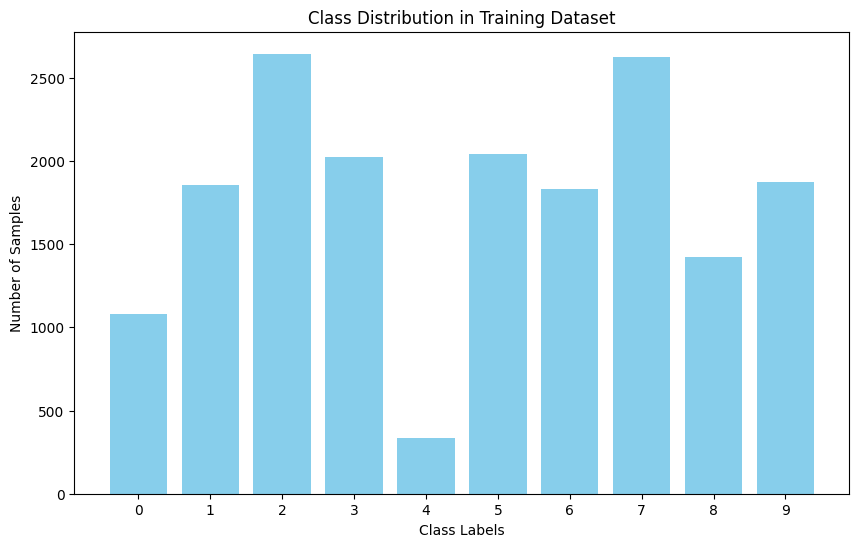

In [ ]:
unique_classes, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(unique_classes)
plt.show()

## resizing images

In [ ]:
images = tf.image.resize(images, (128,128), method='bilinear').numpy()
print(f"Resized images: {images.shape}")

Resized images: (17736, 128, 128, 3)


#splitting dataset

In [ ]:
galaxy10_x_train, galaxy10_x_test, galaxy10_y_train, galaxy10_y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=42)

## normalization

In [ ]:
galaxy10_x_train = galaxy10_x_train.astype('float32') / 255.0
galaxy10_x_test = galaxy10_x_test.astype('float32') / 255.0

## one hot encoding

In [ ]:
galaxy10_y_train = to_categorical(galaxy10_y_train)
galaxy10_y_test = to_categorical(galaxy10_y_test)

## balancing data with class weights

In [ ]:
y_train_indices = np.argmax(galaxy10_y_train, axis=1)
classes = np.unique(y_train_indices)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train_indices)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.617787913340935, 1: 0.9586486486486486, 2: 0.6705103969754254, 3: 0.876343421865349, 4: 5.39467680608365, 5: 0.8828873677660236, 6: 0.9691256830601093, 7: 0.671780303030303, 8: 1.244561403508772, 9: 0.9396026490066225}


# Model Creation

##base architecture

In [ ]:
def create_model(pretrained_model_class, n_trainable_layers=0, weights="imagenet"):
    pretrained_model = pretrained_model_class(include_top=False, weights=weights, input_shape=(128, 128, 3))
    pretrained_model.trainable = False

    if n_trainable_layers > 0:
        for layer in pretrained_model.layers[-n_trainable_layers:]:
            layer.trainable = True

    input_layer = layers.Input((128, 128, 3))
    x = pretrained_model(input_layer)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(10, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
models = {
    "EfficientNetB0": create_model(EfficientNetB0, n_trainable_layers=len(EfficientNetB0().layers)),
    "EfficientNetB3": create_model(EfficientNetB3, n_trainable_layers=len(EfficientNetB3().layers)),
    "EfficientNetB4": create_model(EfficientNetB4, n_trainable_layers=len(EfficientNetB4().layers)),
    "ResNet50": create_model(ResNet50, n_trainable_layers=len(ResNet50().layers)),
    # "InceptionV3": create_model(InceptionV3, n_trainable_layers=len(InceptionV3().layers)),
    # "MobileNetV2": create_model(MobileNetV2, n_trainable_layers=len(MobileNetV2().layers))
}

## model training

In [ ]:
def train_model(model, x_train, y_train, model_name, epochs=50, patience=10, validation_split=0.1):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=patience, restore_best_weights=True
    )
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_split=validation_split,
        callbacks=[early_stopping],
        class_weight=class_weights_dict,
        batch_size=32
    )

    save_path = f"./models/{model_name}.h5"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model.save(save_path)
    return history

In [ ]:
histories = {}
for model_name, model in models.items():
    print(f"Training model: {model_name}")
    histories[model_name] = train_model(model, galaxy10_x_train, galaxy10_y_train, model_name)

Training model: EfficientNetB0
Epoch 1/50


I0000 00:00:1734179774.122722     102 service.cc:145] XLA service 0x7ce85c071b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734179774.122775     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734179774.122779     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/400 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.0469 - loss: 2.6385   

I0000 00:00:1734179819.956114     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 151s 185ms/step - accuracy: 0.3764 - loss: 1.7908 - val_accuracy: 0.1198 - val_loss: 43.2666
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.6529 - loss: 1.0686 - val_accuracy: 0.5039 - val_loss: 1.5219
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.7214 - loss: 0.8705 - val_accuracy: 0.6808 - val_loss: 0.9913
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.7617 - loss: 0.7431 - val_accuracy: 0.6871 - val_loss: 1.0068
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.7848 - loss: 0.6708 - val_accuracy: 0.6667 - val_loss: 1.1705
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8158 - loss: 0.5653 - val_accuracy: 0.7541 - val_loss: 0.8573
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.8320 - loss: 0.5441 - val_accuracy: 0.7336 - val_loss: 0.9184
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.8562 - loss: 0.4504 - val_accu

I0000 00:00:1734180368.752203     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 4 bytes spill stores, 4 bytes spill loads



400/400 ━━━━━━━━━━━━━━━━━━━━ 291s 376ms/step - accuracy: 0.3750 - loss: 1.8070 - val_accuracy: 0.2156 - val_loss: 2.2195
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 110ms/step - accuracy: 0.6424 - loss: 1.0960 - val_accuracy: 0.5250 - val_loss: 1.4568
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.7262 - loss: 0.8856 - val_accuracy: 0.7350 - val_loss: 0.8243
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.7733 - loss: 0.7223 - val_accuracy: 0.7280 - val_loss: 0.8448
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.7882 - loss: 0.6657 - val_accuracy: 0.7336 - val_loss: 0.8370
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.8249 - loss: 0.5560 - val_accuracy: 0.7097 - val_loss: 0.9619
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.8355 - loss: 0.5300 - val_accuracy: 0.7209 - val_loss: 1.0084
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.8570 - loss: 0.4682 - va

I0000 00:00:1734181517.848221     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_2', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 20 bytes spill stores, 20 bytes spill loads



400/400 ━━━━━━━━━━━━━━━━━━━━ 384s 506ms/step - accuracy: 0.3440 - loss: 1.8757 - val_accuracy: 0.1247 - val_loss: 3.2278
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 59s 148ms/step - accuracy: 0.6499 - loss: 1.1146 - val_accuracy: 0.4785 - val_loss: 1.5604
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 146ms/step - accuracy: 0.7065 - loss: 0.9372 - val_accuracy: 0.6751 - val_loss: 1.0353
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 145ms/step - accuracy: 0.7674 - loss: 0.7500 - val_accuracy: 0.6554 - val_loss: 1.2890
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 145ms/step - accuracy: 0.7627 - loss: 0.7672 - val_accuracy: 0.7879 - val_loss: 0.7074
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 144ms/step - accuracy: 0.8252 - loss: 0.5629 - val_accuracy: 0.5955 - val_loss: 1.4810
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 145ms/step - accuracy: 0.8490 - loss: 0.5230 - val_accuracy: 0.7569 - val_loss: 1.0305
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 145ms/step - accuracy: 0.8602 - loss: 0.4532 - va

I0000 00:00:1734182772.174735     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 20 bytes spill stores, 20 bytes spill loads



400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.2160 - loss: 2.1536

I0000 00:00:1734182842.012694     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 20 bytes spill stores, 20 bytes spill loads



400/400 ━━━━━━━━━━━━━━━━━━━━ 134s 194ms/step - accuracy: 0.2162 - loss: 2.1530 - val_accuracy: 0.1043 - val_loss: 2.3058
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 50s 126ms/step - accuracy: 0.3903 - loss: 1.6130 - val_accuracy: 0.1332 - val_loss: 2.2678
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 122ms/step - accuracy: 0.5042 - loss: 1.3629 - val_accuracy: 0.5511 - val_loss: 1.2213
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 123ms/step - accuracy: 0.5904 - loss: 1.1435 - val_accuracy: 0.2727 - val_loss: 8.1620
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 122ms/step - accuracy: 0.5911 - loss: 1.1773 - val_accuracy: 0.5011 - val_loss: 1.3569
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 123ms/step - accuracy: 0.6703 - loss: 0.9740 - val_accuracy: 0.4757 - val_loss: 1.8138
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 123ms/step - accuracy: 0.7090 - loss: 0.8712 - val_accuracy: 0.3164 - val_loss: 2.3421
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 49s 123ms/step - accuracy: 0.7237 - loss: 0.8082 - va

In [ ]:
def ensemble_predict(models, x_test):
    predictions = [model.predict(x_test) for model in models.values()]
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

# Evaluation and Visualization Functions

In [ ]:
def plot_accuracy(history, model_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluating Models on Decals Dataset

## individual model evaluation

Evaluating model: EfficientNetB0
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step


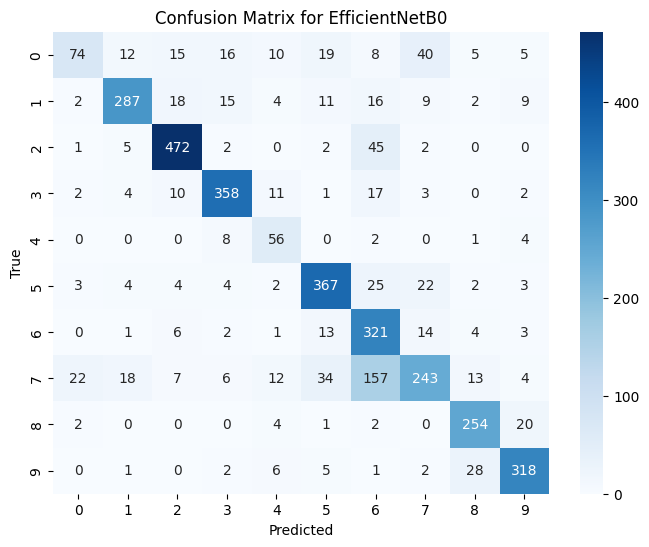

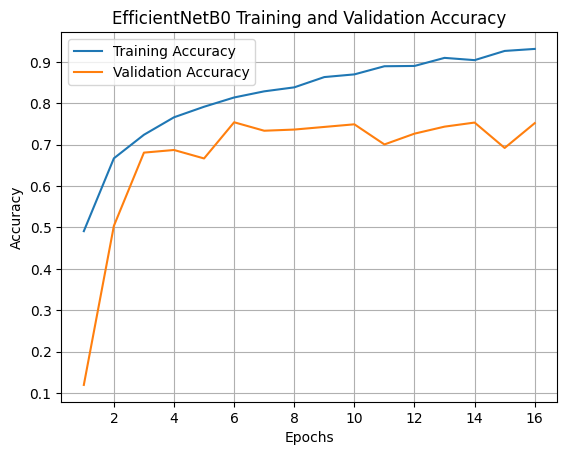

Evaluating model: EfficientNetB3
111/111 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step


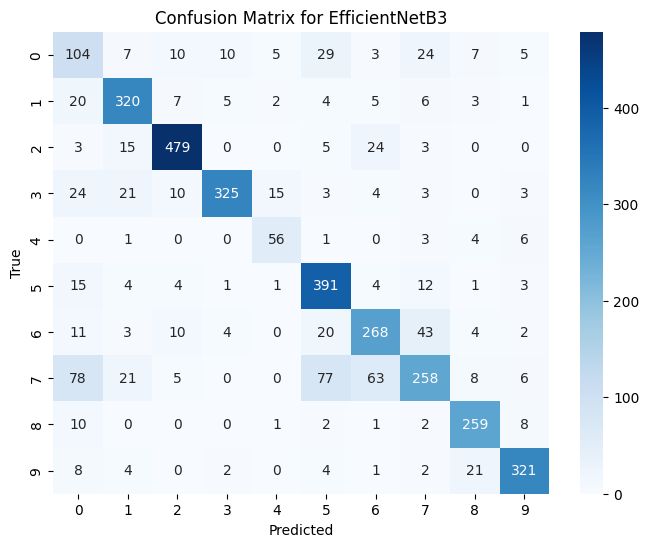

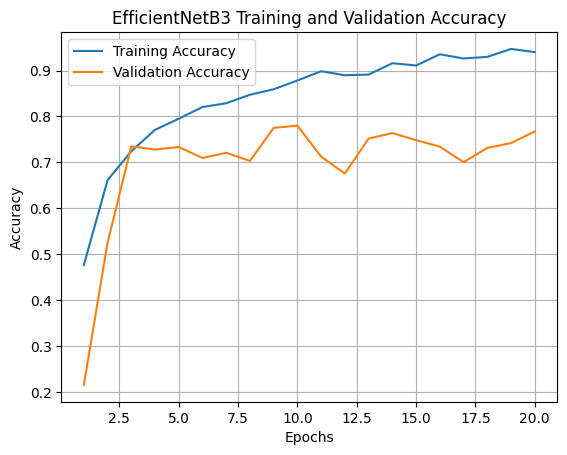

Evaluating model: EfficientNetB4
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step


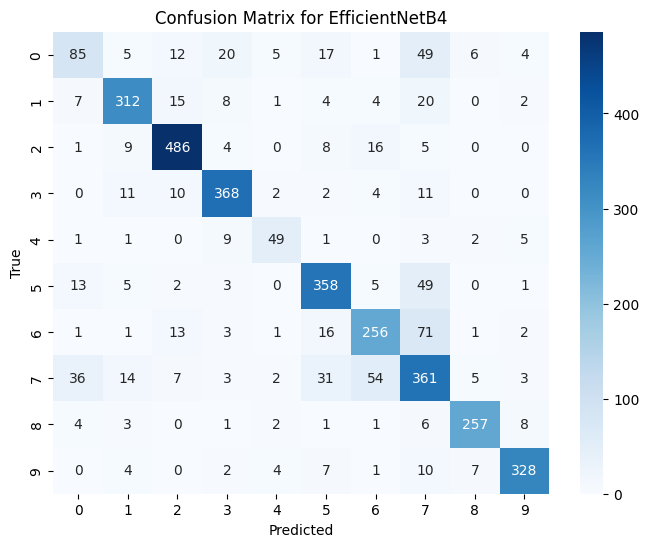

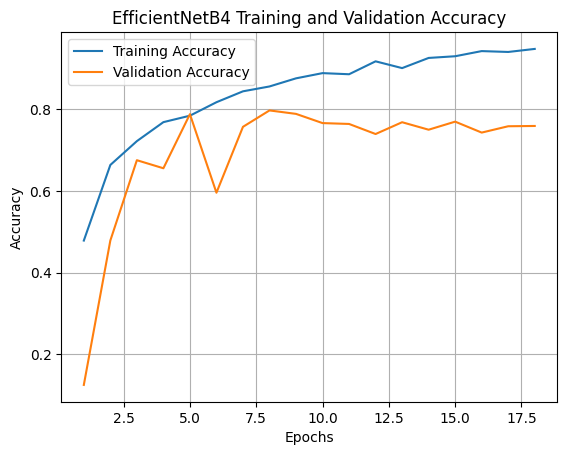

Evaluating model: ResNet50
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step


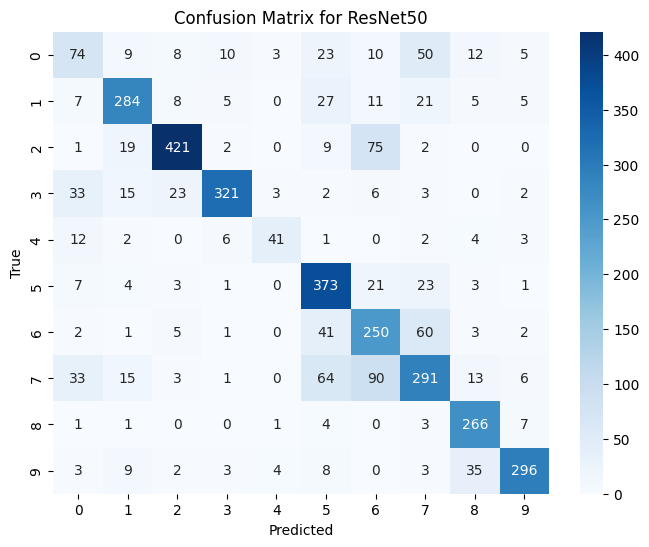

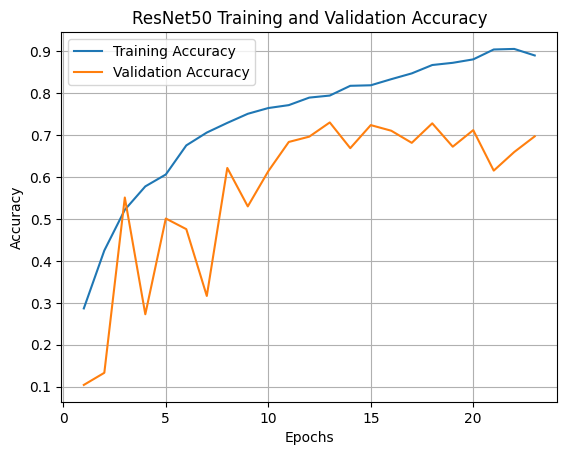

In [ ]:
test_y_true = np.argmax(galaxy10_y_test, axis=1)
for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")
    test_y_pred = np.argmax(model.predict(galaxy10_x_test), axis=1)
    plot_confusion_matrix(test_y_true, test_y_pred, model_name)
    plot_accuracy(histories[model_name], model_name)

In [ ]:
for name,model in models.items():
    print(model.evaluate(galaxy10_x_test,galaxy10_y_test))

111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7728 - loss: 0.7621
[0.7690216302871704, 0.7750845551490784]
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7841 - loss: 0.7728
[0.7573695182800293, 0.7838218808174133]
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.8122 - loss: 0.6722
[0.6836508512496948, 0.8060879111289978]
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7380 - loss: 0.8537
[0.8547016382217407, 0.7375986576080322]


## ensemble model evaluation

In [ ]:
ensemble_predictions = ensemble_predict(models, galaxy10_x_test)
ensemble_accuracy = accuracy_score(test_y_true, ensemble_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy * 100:.2f}%")

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Ensemble Accuracy: 82.98%


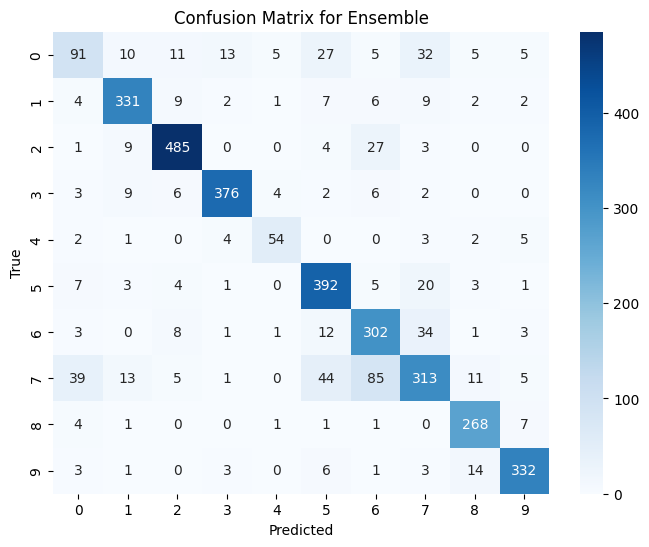

In [ ]:
plot_confusion_matrix(test_y_true, ensemble_predictions, "Ensemble")

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Ensemble Accuracy (excluding ResNet50): 83.20%
Ensemble Precision: 82.97%
Ensemble Recall: 83.20%
Ensemble F1-Score: 82.81%
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.46      0.51       204
           1       0.88      0.89      0.89       373
           2       0.91      0.93      0.92       529
           3       0.92      0.91      0.92       408
           4       0.73      0.73      0.73        71
           5       0.81      0.90      0.85       436
           6       0.70      0.84      0.76       365
           7       0.76      0.60      0.67       516
           8       0.90      0.95      0.92       283
           9       0.92      0.93      0.92       363

    accuracy                           0.83      3548
   macro avg       0.81      0.81      0.81      3548
weighted avg  

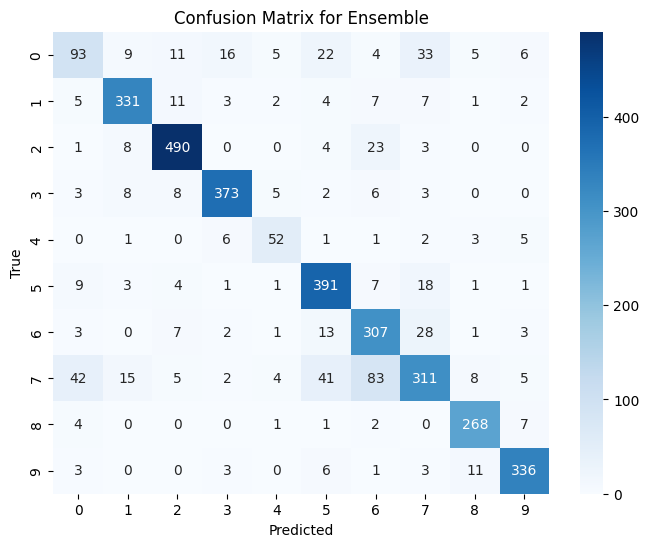

In [ ]:
models_without_resnet50 = {key: value for key, value in models.items() if key != "ResNet50"}
ensemble_predictions = ensemble_predict(models_without_resnet50, galaxy10_x_test)
ensemble_accuracy = accuracy_score(test_y_true, ensemble_predictions)
ensemble_f1 = f1_score(test_y_true, ensemble_predictions, average='weighted')
ensemble_recall = recall_score(test_y_true, ensemble_predictions, average='weighted')
ensemble_precision = precision_score(test_y_true, ensemble_predictions, average='weighted')
print(f"Ensemble Accuracy (excluding ResNet50): {ensemble_accuracy * 100:.2f}%")
print(f"Ensemble Precision: {ensemble_precision * 100:.2f}%")
print(f"Ensemble Recall: {ensemble_recall * 100:.2f}%")
print(f"Ensemble F1-Score: {ensemble_f1 * 100:.2f}%")
print("Detailed Classification Report:")
print(classification_report(test_y_true, ensemble_predictions))
plot_confusion_matrix(test_y_true, ensemble_predictions, "Ensemble")

# Viewing predictions

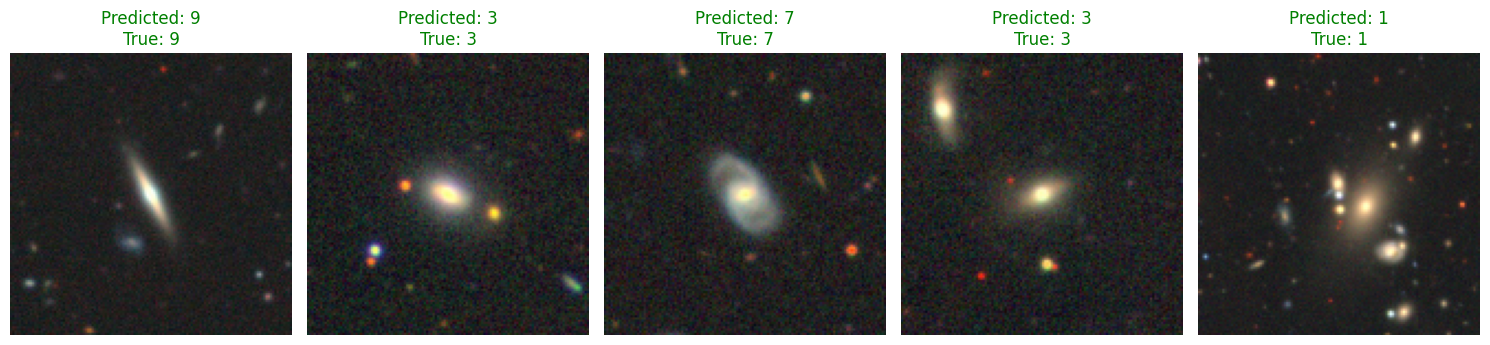

In [ ]:
def plot_random_predictions(test_images, test_labels, predictions, num_images=5):
    indices = random.sample(range(len(test_images)), num_images)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        image = test_images[idx]
        true_label = test_labels[idx]
        predicted_label = predictions[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        title_color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}",
                  color=title_color, fontsize=12)
    plt.tight_layout()
    plt.show()
plot_random_predictions(galaxy10_x_test, test_y_true, ensemble_predictions)


# Generalization on SDSS dataset

##loading previously saved models

In [ ]:
model_names = ["EfficientNetB0", "EfficientNetB3", "EfficientNetB4", "ResNet50"]
models_dir = '/kaggle/working/models'
models = {}
for model_name in model_names:
    model_path = os.path.join(models_dir, f"{model_name}.h5")
    if os.path.exists(model_path):
        models[model_name] = load_model(model_path)
        print(f"Loaded {model_name} from {model_path}")
    else:
        print(f"Model file {model_name}.h5 not found in {models_dir}")
models['EfficientNetB0'].summary()

Loaded EfficientNetB0 from /kaggle/working/models/EfficientNetB0.h5
Loaded EfficientNetB3 from /kaggle/working/models/EfficientNetB3.h5
Loaded EfficientNetB4 from /kaggle/working/models/EfficientNetB4.h5
Loaded ResNet50 from /kaggle/working/models/ResNet50.h5


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_68 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_23     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,249,135 (16.21 MB)

 Trainable params: 4,207,110 (16.05 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 2 (12.00 B)

## Loading and prepping dataset, similar to decals dataset

In [ ]:
sd_images, sd_labels = load_galaxy10sdss()

/root/.astroNN/datasets/Galaxy10.h5 was found!


In [ ]:
print("Initial images shape:", sd_images.shape)
print("Initial labels shape:", sd_labels.shape)

Initial images shape: (21785, 69, 69, 3)
Initial labels shape: (21785,)


In [ ]:
sd_images = tf.image.resize(sd_images, (128, 128), method='bilinear').numpy()
print(f"Resized images: {sd_images.shape}")

Resized images: (21785, 128, 128, 3)


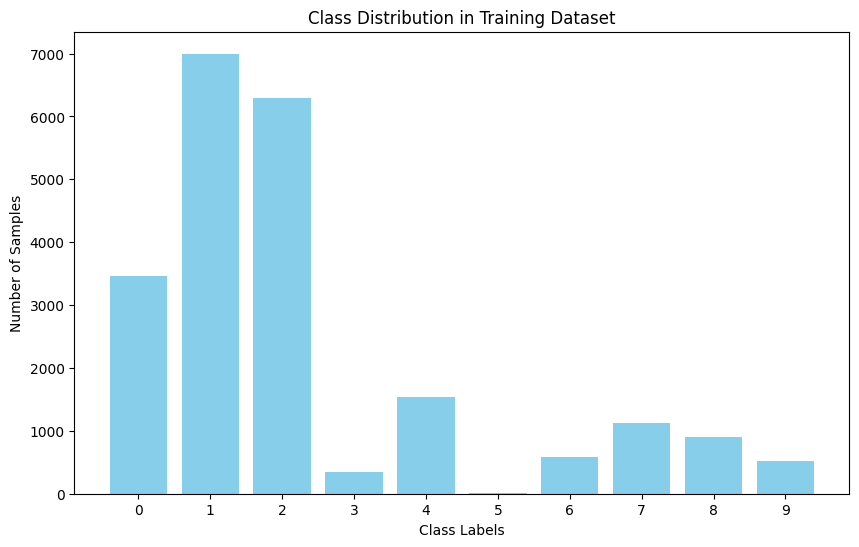

In [ ]:

sd_unique_classes, sd_counts = np.unique(sd_labels, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(sd_unique_classes, sd_counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(sd_unique_classes)
plt.show()

In [ ]:
sd_galaxy10_x_train, sd_galaxy10_x_test, sd_galaxy10_y_train, sd_galaxy10_y_test = train_test_split(
    sd_images, sd_labels, test_size=0.2, shuffle=True, random_state=42
)

In [ ]:
sd_galaxy10_x_train = sd_galaxy10_x_train.astype('float32') / 255.0
sd_galaxy10_x_test = sd_galaxy10_x_test.astype('float32') / 255.0

In [ ]:
sd_galaxy10_y_train = to_categorical(sd_galaxy10_y_train)
sd_galaxy10_y_test = to_categorical(sd_galaxy10_y_test)

In [ ]:
sd_images, sd_labels = load_galaxy10sdss()

/root/.astroNN/datasets/Galaxy10.h5 was found!


In [ ]:
print("Initial images shape:", sd_images.shape)
print("Initial labels shape:", sd_labels.shape)

Initial images shape: (21785, 69, 69, 3)
Initial labels shape: (21785,)


In [ ]:
sd_images = tf.image.resize(sd_images, (128, 128), method='bilinear').numpy()
print(f"Resized images: {sd_images.shape}")

Resized images: (21785, 128, 128, 3)


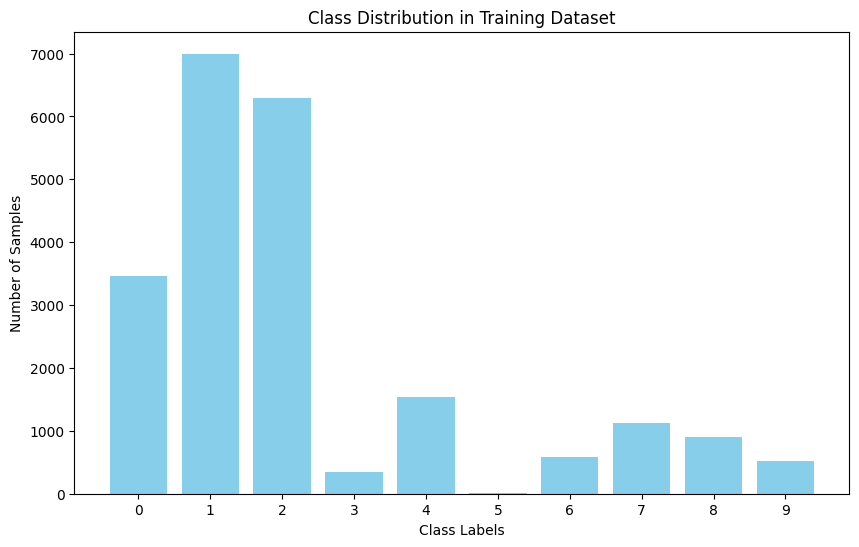

In [ ]:

sd_unique_classes, sd_counts = np.unique(sd_labels, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(sd_unique_classes, sd_counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(sd_unique_classes)
plt.show()

In [ ]:
sd_galaxy10_x_train, sd_galaxy10_x_test, sd_galaxy10_y_train, sd_galaxy10_y_test = train_test_split(
    sd_images, sd_labels, test_size=0.2, shuffle=True, random_state=42
)

In [ ]:
sd_galaxy10_x_train = sd_galaxy10_x_train.astype('float32') / 255.0
sd_galaxy10_x_test = sd_galaxy10_x_test.astype('float32') / 255.0

In [ ]:
sd_galaxy10_y_train = to_categorical(sd_galaxy10_y_train)
sd_galaxy10_y_test = to_categorical(sd_galaxy10_y_test)

##mapping classes to similar classes in decals dataset (since models are trained on it)

In [ ]:
class_mapping = {
    2: 1,
    3: 2,
    4: 3,
    6: 7,
    7: 9,
    8: 6,
    9: [4, 5]
}

In [ ]:
def map_and_filter(sd_x, sd_y, class_mapping):
    sd_y_true = np.argmax(sd_y, axis=1)
    valid_indices = []
    new_labels = []

    for i, label in enumerate(sd_y_true):
        if label in [0, 8]:
            continue

        mapped_label = None

        for mapped_class, original_class in class_mapping.items():
            if isinstance(original_class, list):
                if label in original_class:
                    mapped_label = mapped_class
                    break
            elif label == original_class:
                mapped_label = mapped_class
                break

        if mapped_label is not None:
            valid_indices.append(i)
            new_labels.append(mapped_label)

    # Filter and remap data
    filtered_x = sd_x[valid_indices]
    filtered_y = np.zeros((len(valid_indices), 10))
    filtered_y[np.arange(len(valid_indices)), new_labels] = 1

    return filtered_x, filtered_y


In [ ]:
filtered_sd_x_test, filtered_sd_y_test = map_and_filter(sd_galaxy10_x_test, sd_galaxy10_y_test, class_mapping)

# Evaluating Model on SDSS dataset

In [ ]:
for name,model in models.items():
    print(model.evaluate(filtered_sd_x_test,filtered_sd_y_test))

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4981 - loss: 1.7286
[1.7236303091049194, 0.5041275024414062]
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4437 - loss: 2.1693
[2.1695311069488525, 0.4560205042362213]
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5270 - loss: 2.0441
[2.0138769149780273, 0.5345858335494995]
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4467 - loss: 2.4416
[2.4172215461730957, 0.45288926362991333]


In [ ]:
ensemble_predictions = ensemble_predict(models, filtered_sd_x_test)
ensemble_accuracy = accuracy_score(test_y_true, ensemble_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy * 100:.2f}%")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Ensemble Accuracy: 53.60%


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Ensemble Accuracy (excluding ResNet50): 55.28%
Ensemble Precision: 71.86%
Ensemble Recall: 55.28%
Ensemble F1-Score: 53.20%
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.69      0.88      0.77      1464
           3       0.87      0.21      0.34      1235
           4       0.00      0.00      0.00        64
           5       0.00      0.00      0.00         0
           6       0.29      0.73      0.41       240
           7       0.41      0.41      0.41        96
           8       0.46      0.97      0.62       121
           9       0.96      0.23      0.37       293

    accuracy                           0.55      3513
   macro avg       0.37      0.34      0.29      3513
weighted avg       0.72      0.55      0.53      3513



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
/opt/conda/lib

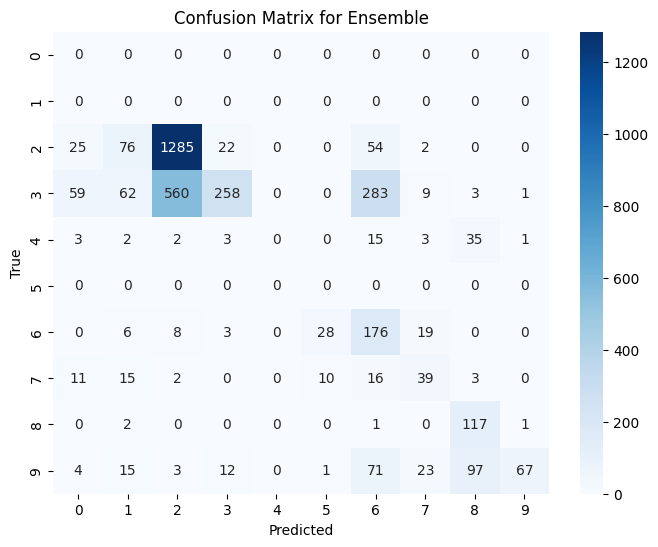

In [ ]:
test_y_true = np.argmax(filtered_sd_y_test, axis=1)
models_without_resnet50 = {key: value for key, value in models.items() if key not in  ["ResNet50","EfficientNetB3"]}
ensemble_predictions = ensemble_predict(models_without_resnet50, filtered_sd_x_test)
ensemble_accuracy = accuracy_score(test_y_true, ensemble_predictions)
ensemble_f1 = f1_score(test_y_true, ensemble_predictions, average='weighted')
ensemble_recall = recall_score(test_y_true, ensemble_predictions, average='weighted')
ensemble_precision = precision_score(test_y_true, ensemble_predictions, average='weighted')
print(f"Ensemble Accuracy (excluding ResNet50): {ensemble_accuracy * 100:.2f}%")
print(f"Ensemble Precision: {ensemble_precision * 100:.2f}%")
print(f"Ensemble Recall: {ensemble_recall * 100:.2f}%")
print(f"Ensemble F1-Score: {ensemble_f1 * 100:.2f}%")
print("Detailed Classification Report:")
print(classification_report(test_y_true, ensemble_predictions))
plot_confusion_matrix(test_y_true, ensemble_predictions, "Ensemble")